<a href="https://colab.research.google.com/github/Rahca2308/SE_PROJECT2/blob/main/SolarProject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#this can be used to import from local directory, but not necessary if git repo is just importet as below.
#import io
#from google.colab import files
#uploaded = files.upload()

In [ ]:
!git clone https://github.com/martavp/SOLAR_ENERGY_project/

Cloning into 'SOLAR_ENERGY_project'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 117 (delta 39), reused 35 (delta 11), pack-reused 0
Receiving objects: 100% (117/117), 2.27 MiB | 13.84 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [ ]:
#change into the Martas solar energy project
%cd SOLAR_ENERGY_project

/content/SOLAR_ENERGY_project


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
from datetime import timedelta

from solarfun import (calculate_B_0_horizontal,
                      calculate_G_ground_horizontal,                      
                      calculate_diffuse_fraction,
                      calculate_incident_angle)

1. Model the hourly global radiation on a horizontal surface G(0,t) in Aarhus during 2018. Assume that the clearness index is Kt=0.7 for every hour. Plot the global radiation on a horizontal surface for the first week of February and the first week of June 2018.


In [ ]:
# tilt representes inclination of the solar panel (in degress), orientation
# in degress (south=0)
tilt=0;
orientation=0;
lat = 56.162939 # latitude of Aarhus
lon = 10.203921 # longitude of Aarhus
Kt=0.7

year = 2018
hour_0 = datetime(year,1,1,0,0,0) - timedelta(hours=1)

hours = [datetime(year,1,1,0,0,0) 
         + timedelta(hours=i) for i in range(0,24*365)]
hours_str = [hour.strftime("%Y-%m-%d %H:%M ") for hour in hours]

timeseries = pd.DataFrame(
            index=pd.Series(
                data = hours,
                name = 'utc_time'),
            columns = pd.Series(
                data = ['B_0_h', 'K_t', 'G_ground_h', 'solar_altitude', 'F', 
                        'B_ground_h', 'D_ground_h', 'incident_angle', 
                        'B_tilted', 'D_tilted', 'R_tilted', 'G_tilted'], 
                name = 'names')
            )

# Calculate extraterrestrial irradiance
timeseries['B_0_h'] = calculate_B_0_horizontal(hours, hour_0, lon, lat)  

# Clearness index is assumed to be equal to 0.7 at every hour
timeseries['K_t']=Kt*np.ones(len(hours))  

# Calculate global horizontal irradiance on the ground
[timeseries['G_ground_h'], timeseries['solar_altitude']] = calculate_G_ground_horizontal(hours, hour_0, lon, lat, timeseries['K_t'])

# Calculate diffuse fraction -#What model are we using???? - solarfun function seems to not use Page model Fd=1-1.14K
timeseries['F'] = calculate_diffuse_fraction(hours, hour_0, lon, lat, timeseries['K_t'])

# Calculate direct and diffuse irradiance on the horizontal surface
timeseries['B_ground_h']=[x*(1-y) for x,y in zip(timeseries['G_ground_h'], timeseries['F'])]
timeseries['D_ground_h']=[x*y for x,y in zip(timeseries['G_ground_h'], timeseries['F'])]



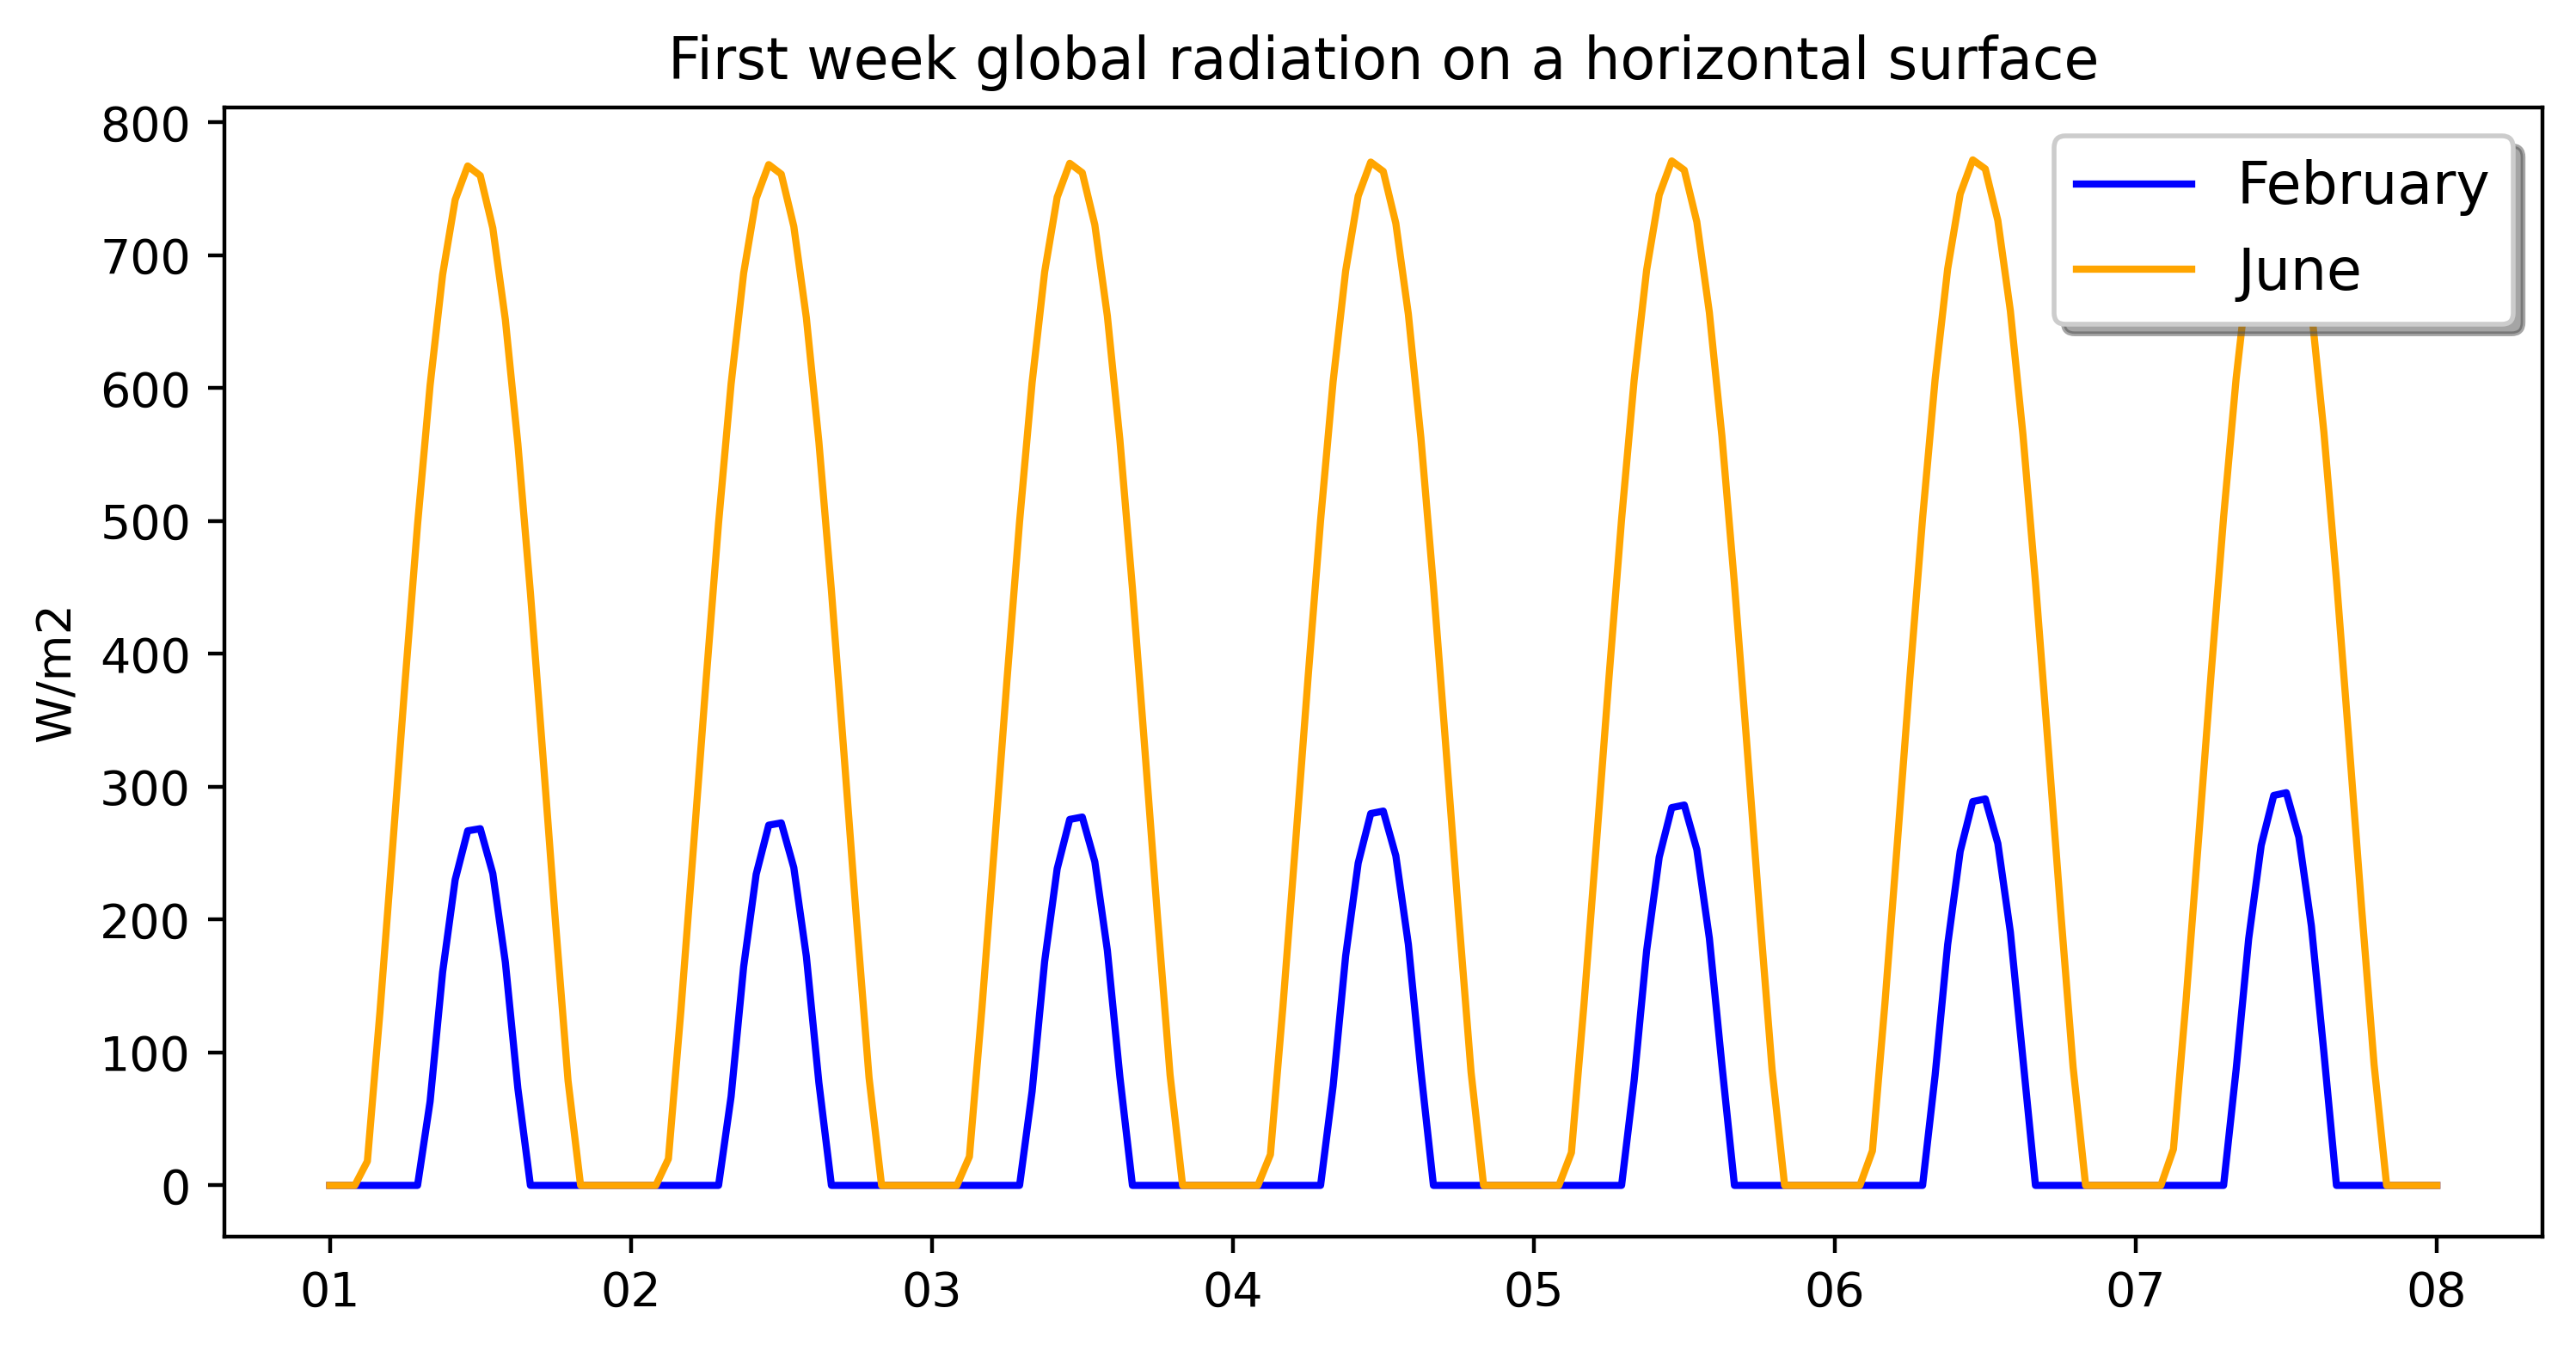

In [ ]:

import matplotlib.dates as mdates
plt.rcParams["figure.figsize"] = (15,5)
# plot
plt.figure(figsize=(20, 10),dpi=400)

gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.3, hspace=0.3)
ax1 = plt.subplot(gs1[0,0])
ax1.plot(timeseries['G_ground_h']['2018-02-01 00:00':'2018-02-08 00:00'], 
         label='February', color='blue')
ax1.plot(timeseries['2018-02-01 00:00':'2018-02-08 00:00'].index,timeseries.loc['2018-06-01 00:00':'2018-06-08 00:00','G_ground_h'].values, 
         label='June', color= 'orange') #Use february as x axis, but plot july as the y points
plt.title('First week global radiation on a horizontal surface')
ax1.legend(fancybox=True, shadow=True,fontsize=12, loc='upper right')
ax1.set_ylabel('W/m2')
date_form = mdates.DateFormatter("%d")
ax1.xaxis.set_major_formatter(date_form)

plt.show()

*3. Let’s assume that diffuse fraction can be calculated as FD = Cloud cover/100. Estimate the direct and diffuse radiation on the horizontal surface in Aarhus.*



In [ ]:
#Make column with cloud over
weather = pd.read_csv('https://raw.githubusercontent.com/martavp/SOLAR_ENERGY_project/master/weather_station/weather_data.csv',sep=';',index_col=0)
weather.index = pd.to_datetime(weather.index) #Reindex to datetime datatype
weather = weather[~weather.index.duplicated()] #Remove apparent duplicate
weather=weather[:-1] #remove last value, thats corrupt
weather=weather.reindex(timeseries.index, method='nearest') #convert time to same time as timeseries. Fill NaN values with "nearest"


In [ ]:
# Calculate
weather['FD']=weather['Cloud']/100 #FD=Cloudcover/100
timeseries['FD']=weather['FD'] #copy columns to the timeseries dataframe
timeseries['D_ground_h']=timeseries['G_ground_h']*timeseries['FD'] #Diffusive is diffusive fraction * global irradiance
timeseries['B_ground_h']=(1-timeseries['FD'])*timeseries['G_ground_h'] #direct is the rest

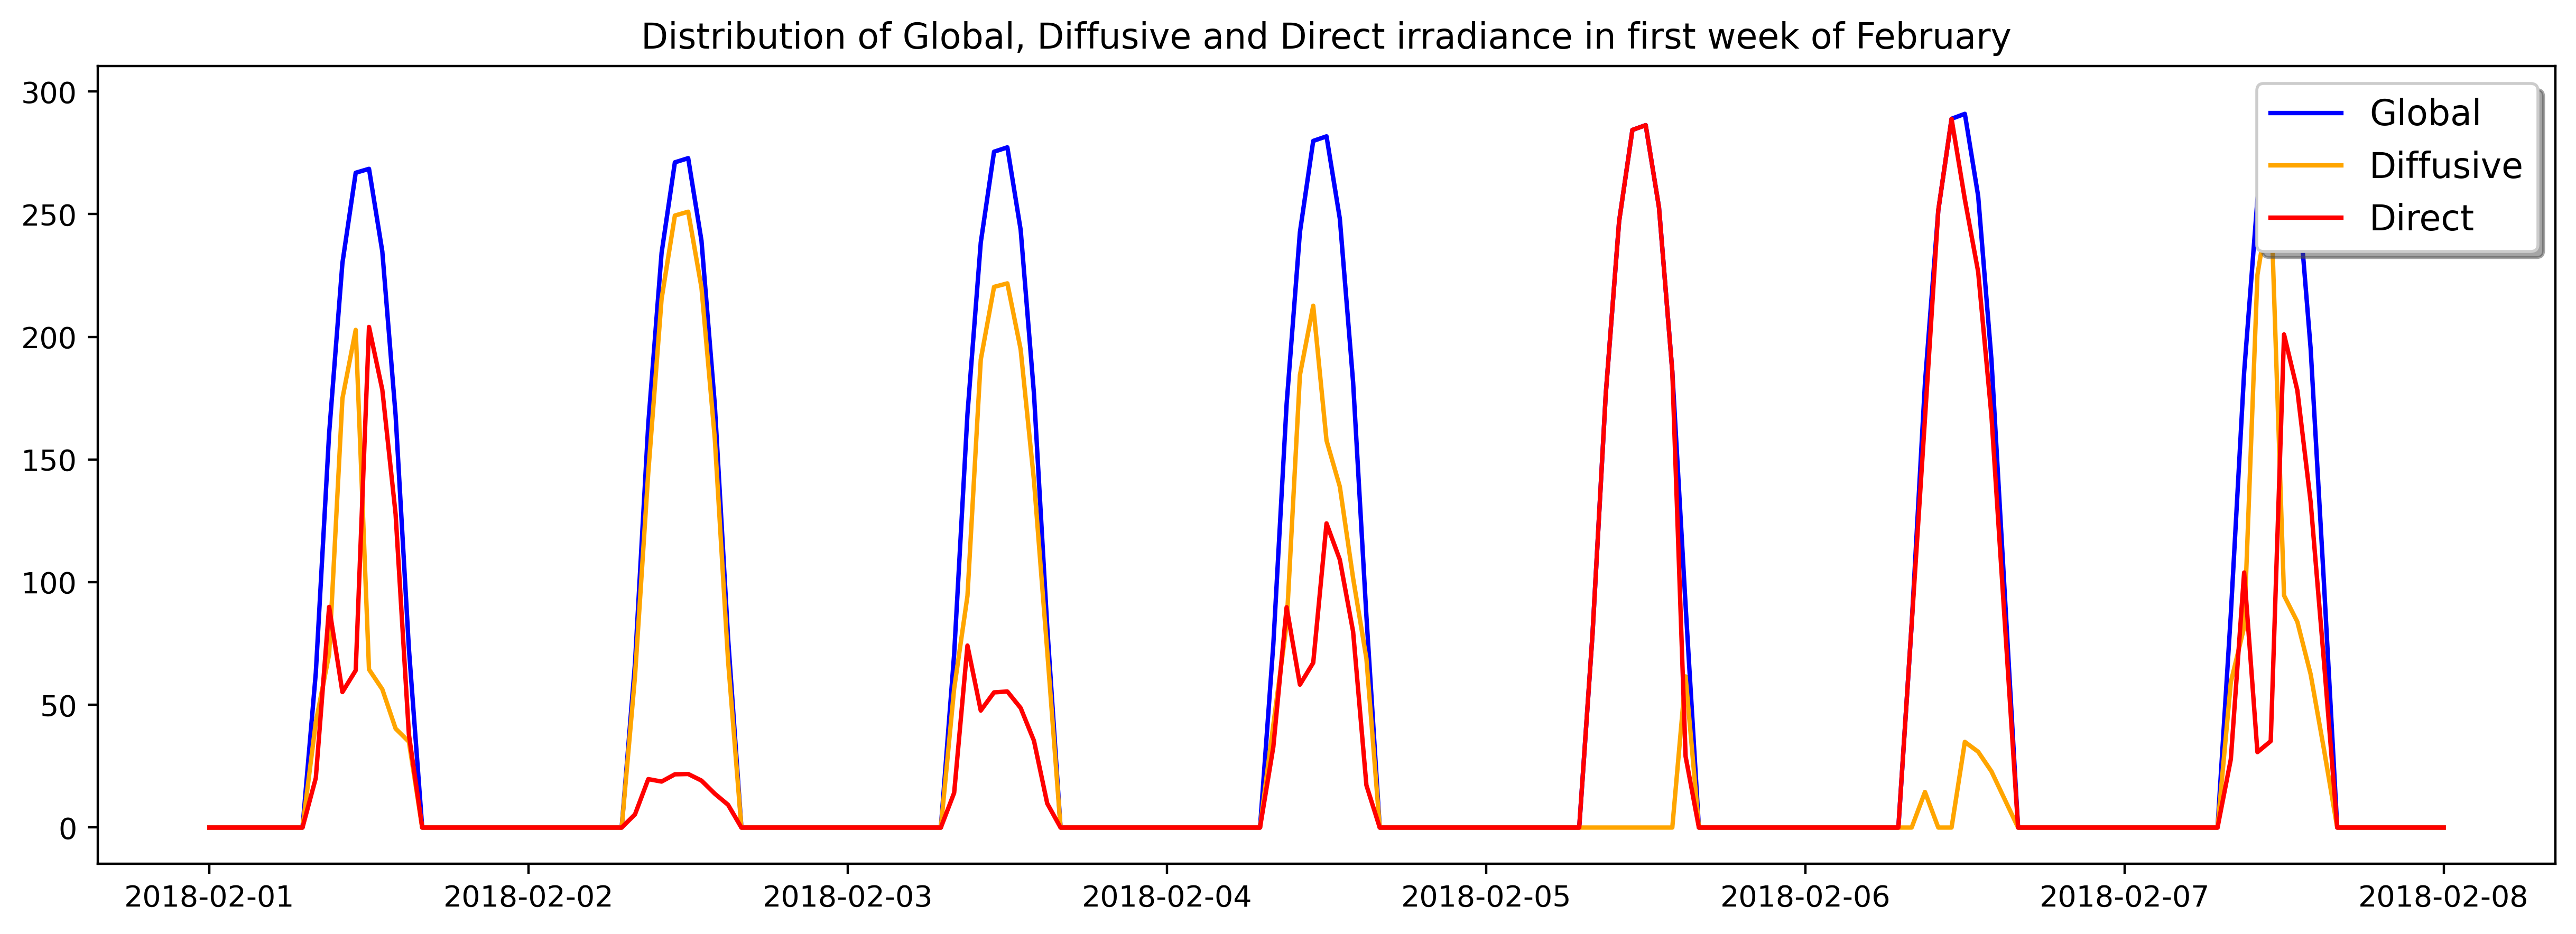

In [ ]:
plt.figure(dpi=400)
plt.plot(timeseries['G_ground_h']['2018-02-01 00:00':'2018-02-08 00:00'], 
         label='Global', color='blue')
plt.plot(timeseries['D_ground_h']['2018-02-01 00:00':'2018-02-08 00:00'], 
         label='Diffusive', color='orange')
plt.plot(timeseries['B_ground_h']['2018-02-01 00:00':'2018-02-08 00:00'], 
         label='Direct', color='red')
plt.legend(fancybox=True, shadow=True,fontsize=12, loc='upper right')
plt.title('Distribution of Global, Diffusive and Direct irradiance in first week of February')
plt.show()

*5. Now we will start modelling the irradiance on the surface of PV panels. Go to the installations at the rooftop of Navitas (you can get there by the stairs close to room 06.138) and measure the orientation and inclination of the solar panels. You can use your phone to get some apps that include a compass and a level gauge. Annotate the orientation and tilt angle of the PV panels.*



In [ ]:
# tilt representes inclination of the solar panel (in degress), orientation
# in degress (south=0)
tilt=13.5;
orientation=5; #SSE - google maps

*Model the direct, diffuse, and albedo irradiance on the solar panels. Select one of the models for diffuse radiation that we have discussed in class (either the isotropic sky or the circumsolar diffuse
Solar Energy Project 2: Modelling radiation and electricity generation
radiation). Assume that reflectivity is ρ=0.05. Plot the global radiation on the PV panels surface for the first week of February and the first week of June 2018.*

In [ ]:
rho=0.05
#Calculate incident angle
timeseries['incident_angle'] = calculate_incident_angle(hours, hour_0, lon, lat,  tilt, orientation)

#Calculate Direct (B) irradiance on solar panel 
for i in timeseries.index:
  if np.cos(timeseries['incident_angle'][i]/180*np.pi) > 0:
      timeseries['B_tilted'][i]=np.cos(timeseries['incident_angle'][i]/180*np.pi)*timeseries['B_ground_h'][i]
  else:
      timeseries['B_tilted'][i]=0
#
#Calculate diffuse (D) irradiance on solar panel ##ISOTROPIC
timeseries['D_tilted']=[x*(1-np.cos(tilt/180*np.pi))/2 for x in timeseries['D_ground_h']]

#Calculate albedo (R)
timeseries['R_tilted']=[rho*x*(1-np.cos(tilt/180*np.pi))/2 for x in timeseries['G_ground_h']]

#Calculate global irradiance on solar panel
timeseries['G_tilted']=timeseries['B_tilted']+timeseries['D_tilted']+timeseries['R_tilted']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# plot
plt.figure(figsize=(20, 10), dpi=400)
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.3, hspace=0.3)
ax1 = plt.subplot(gs1[0,0])
ax1.plot(timeseries['G_tilted']['2018-02-01 00:00':'2018-02-08 00:00'], 
         label='February', color='blue')
ax1.plot(timeseries['2018-02-01 00:00':'2018-02-08 00:00'].index,timeseries.loc['2018-06-01 00:00':'2018-06-08 00:00','G_tilted'].values, 
         label='June', color= 'orange') #Use february as x axis, but plot july as the y points
plt.title('First week global radiation on a solar panel surface')
ax1.legend(fancybox=True, shadow=True,fontsize=12, loc='upper right')
ax1.set_ylabel('W/m2')
date_form = mdates.DateFormatter("%d")
ax1.xaxis.set_major_formatter(date_form)

plt.show()


*6. The installation comprises 1000 solar panels of monocrystalline Silicon with a rated power of 255 Wp. The characteristics of the solar panel can be found here. Estimated the power produced by the installation at every hour taking into account the irradiance at the entrance of the solar panels and the power decrease due to ambient temperature.*

In [ ]:
Pmax=255
NOCT=45
gamma=-0.44/100
TcSTC=25

#Cell temepratur:
#Tc=Tair+(NOCT-20)*G/800
timeseries['Tc']=[x+(NOCT-20)*y/800 for x,y in zip(weather['Temp'],timeseries['G_tilted'])]

#Produced power
#P=G/1000*(1+gamma*(Tc-TcSTC))*Pmax
timeseries['P']=[y/1000*(1+gamma*(x-TcSTC))*Pmax for x,y in zip(timeseries['Tc'],timeseries['G_tilted'])]
timeseries['P_total']=[x*1000 for x in timeseries['P']]

In [ ]:
timeseries['2018-06-03 08:00':'2018-06-03 18:00']

names,B_0_h,K_t,G_ground_h,solar_altitude,F,B_ground_h,D_ground_h,incident_angle,B_tilted,D_tilted,R_tilted,G_tilted,FD,Tc,P,P_total
utc_time,,,,,,,,,,,,,,,,
2018-06-03 08:00:00,863.029042,0.7,604.120329,40.547335,0.290763,604.120329,0.0,46.707283,414.261,0.0,0.417297,414.678,0.0,31.858694,102.551809,102551.808555
2018-06-03 09:00:00,982.033309,0.7,687.423316,47.707222,0.306630,687.423316,0.0,36.132573,555.201,0.0,0.474839,555.676,0.0,38.264862,133.427054,133427.054063
2018-06-03 10:00:00,1062.476570,0.7,743.733599,53.159692,0.317355,743.733599,0.0,26.876030,663.4,0.0,0.513735,663.914,0.0,43.147320,155.779978,155779.977551
2018-06-03 11:00:00,1098.876751,0.7,769.213726,55.866068,0.322208,769.213726,0.0,21.096650,717.657,0.0,0.531336,718.188,0.0,46.843381,165.536436,165536.435605
2018-06-03 12:00:00,1088.753240,0.7,762.127268,55.095069,0.320858,762.127268,0.0,21.901715,707.121,0.0,0.526441,707.647,0.0,47.413976,162.653793,162653.793423
2018-06-03 13:00:00,1032.795937,0.7,722.957156,51.073519,0.313398,722.957156,0.0,28.730645,633.953,0.0,0.499384,634.453,0.0,46.226647,146.675124,146675.124087
2018-06-03 14:00:00,934.818239,0.7,654.372767,44.761012,0.300335,654.372767,0.0,38.405108,512.791,0.0,0.452009,513.243,0.0,43.438857,120.258890,120258.889777
2018-06-03 15:00:00,801.497165,0.7,561.048016,37.137307,0.282560,561.048016,0.0,49.123809,367.165,0.0,0.387545,367.552,0.0,38.786010,88.040579,88040.578714
2018-06-03 16:00:00,641.918326,0.7,449.342828,28.915850,0.261284,449.342828,0.0,60.128235,223.8,0.0,0.310384,224.11,0.0,33.803447,54.934482,54934.481792


*7. The power produced by the installation is measured every hour. The Facility Management at Navitas has provided the file “CTS Data Aflæsning Strom.xls”. Plot the measured production for the first week of February and the first week of June 2018.*

In [ ]:
#change to pv_data
%cd pv_data

/content/SOLAR_ENERGY_project/pv_data


In [ ]:
#Load data from aflæsning
power =pd.read_excel('CTS Data Aflæsning Strom.xlsx',index_col=[1],header=[2])

In [ ]:
power=power.drop(columns=['Uge', 'Dag','Unnamed: 0','Today','Total']) #drop not needed columns
power = power.iloc[::-1] #revert time so 2018 is first
power=power.stack() #make it to pandas series
timeseries = timeseries.iloc[744:] #Remove january from timeseries
power = power.shift(-1)
power=power[0:(8760-744)] #make same length as timeseries 2018 february 2018 december

timeseries['P_meas']=power.values #add to timeseries 

In [ ]:
# plot
plt.figure(figsize=(20, 10), dpi=400)
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.3, hspace=0.3)
ax1 = plt.subplot(gs1[0,0])
ax1.plot(timeseries['P']['2018-02-01 00:00':'2018-02-08 00:00'], 
         label='P_calculated', color='black')
ax1.plot(timeseries['P_meas']['2018-02-01 00:00':'2018-02-08 00:00'], 
         label='P_meas', color='green')
plt.title('Difference between measured and calculated, February')
ax1.legend(fancybox=True, shadow=True,fontsize=12, loc='upper right')
ax1.set_ylabel('kW')
date_form = mdates.DateFormatter("%d")
ax1.xaxis.set_major_formatter(date_form)

plt.show()

In [ ]:
# plot
plt.figure(figsize=(20, 10), dpi=400)
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.3, hspace=0.3)
ax1 = plt.subplot(gs1[0,0])
ax1.plot(timeseries['P_meas']['2018-02-01 00:00':'2018-02-08 00:00'], 
         label='February', color='blue')
ax1.plot(timeseries['2018-02-01 00:00':'2018-02-08 00:00'].index,timeseries.loc['2018-06-01 00:00':'2018-06-08 00:00','P_meas'].values, 
         label='June', color= 'orange') #Use february as x axis, but plot july as the y points
plt.title('P_meas')
ax1.legend(fancybox=True, shadow=True,fontsize=12, loc='upper right')
ax1.set_ylabel('kW')
date_form = mdates.DateFormatter("%d")
ax1.xaxis.set_major_formatter(date_form)

plt.show()

8. Calculate the relative root mean square error (RMSE), that is the RMSE divide by the mean value, between the modelled generation and the historical measurements. Calculate the error using hourly generation values, as well as aggregating them per day, week, and month. How does the error change when we considered longer time periods?

In [ ]:
#Mean values taken to be the measured power
RRMSE_hourly = (((timeseries.P - timeseries.P_meas) ** 2).mean() ** .5)/timeseries.P_meas.mean()
print('Hourly RRMSE is:{:0.3f}'.format(RRMSE_hourly))


Hourly RRMSE is:1.042


In [ ]:
powererrors = pd.DataFrame()
powererrors['P'] = timeseries['P']
powererrors['P_meas'] = timeseries['P_meas']

#Daily
PEday=powererrors.copy()
PEday=PEday.resample('D').sum()
RRMSE_daily = (((PEday.P - PEday.P_meas) ** 2).mean() ** .5)/PEday.P_meas.mean()
print('Daily RRMSE is:{:0.3f}'.format(RRMSE_daily))

#weekly
PEweek=powererrors.copy()
PEweek=PEweek.resample('W').sum()
RRMSE_weekly = (((PEweek.P - PEweek.P_meas) ** 2).mean() ** .5)/PEweek.P_meas.mean()
print('Weekly RRMSE is:{:0.3f}'.format(RRMSE_weekly))

#monthly
PEmonth=powererrors.copy()
PEmonth=PEmonth.resample('M').sum()
RRMSE_month = (((PEmonth.P - PEmonth.P_meas) ** 2).mean() ** .5)/PEmonth.P_meas.mean()
print('Monthly RRMSE is:{:0.3f}'.format(RRMSE_month))

Daily RRMSE is:0.426
Weekly RRMSE is:0.349
Monthly RRMSE is:0.323


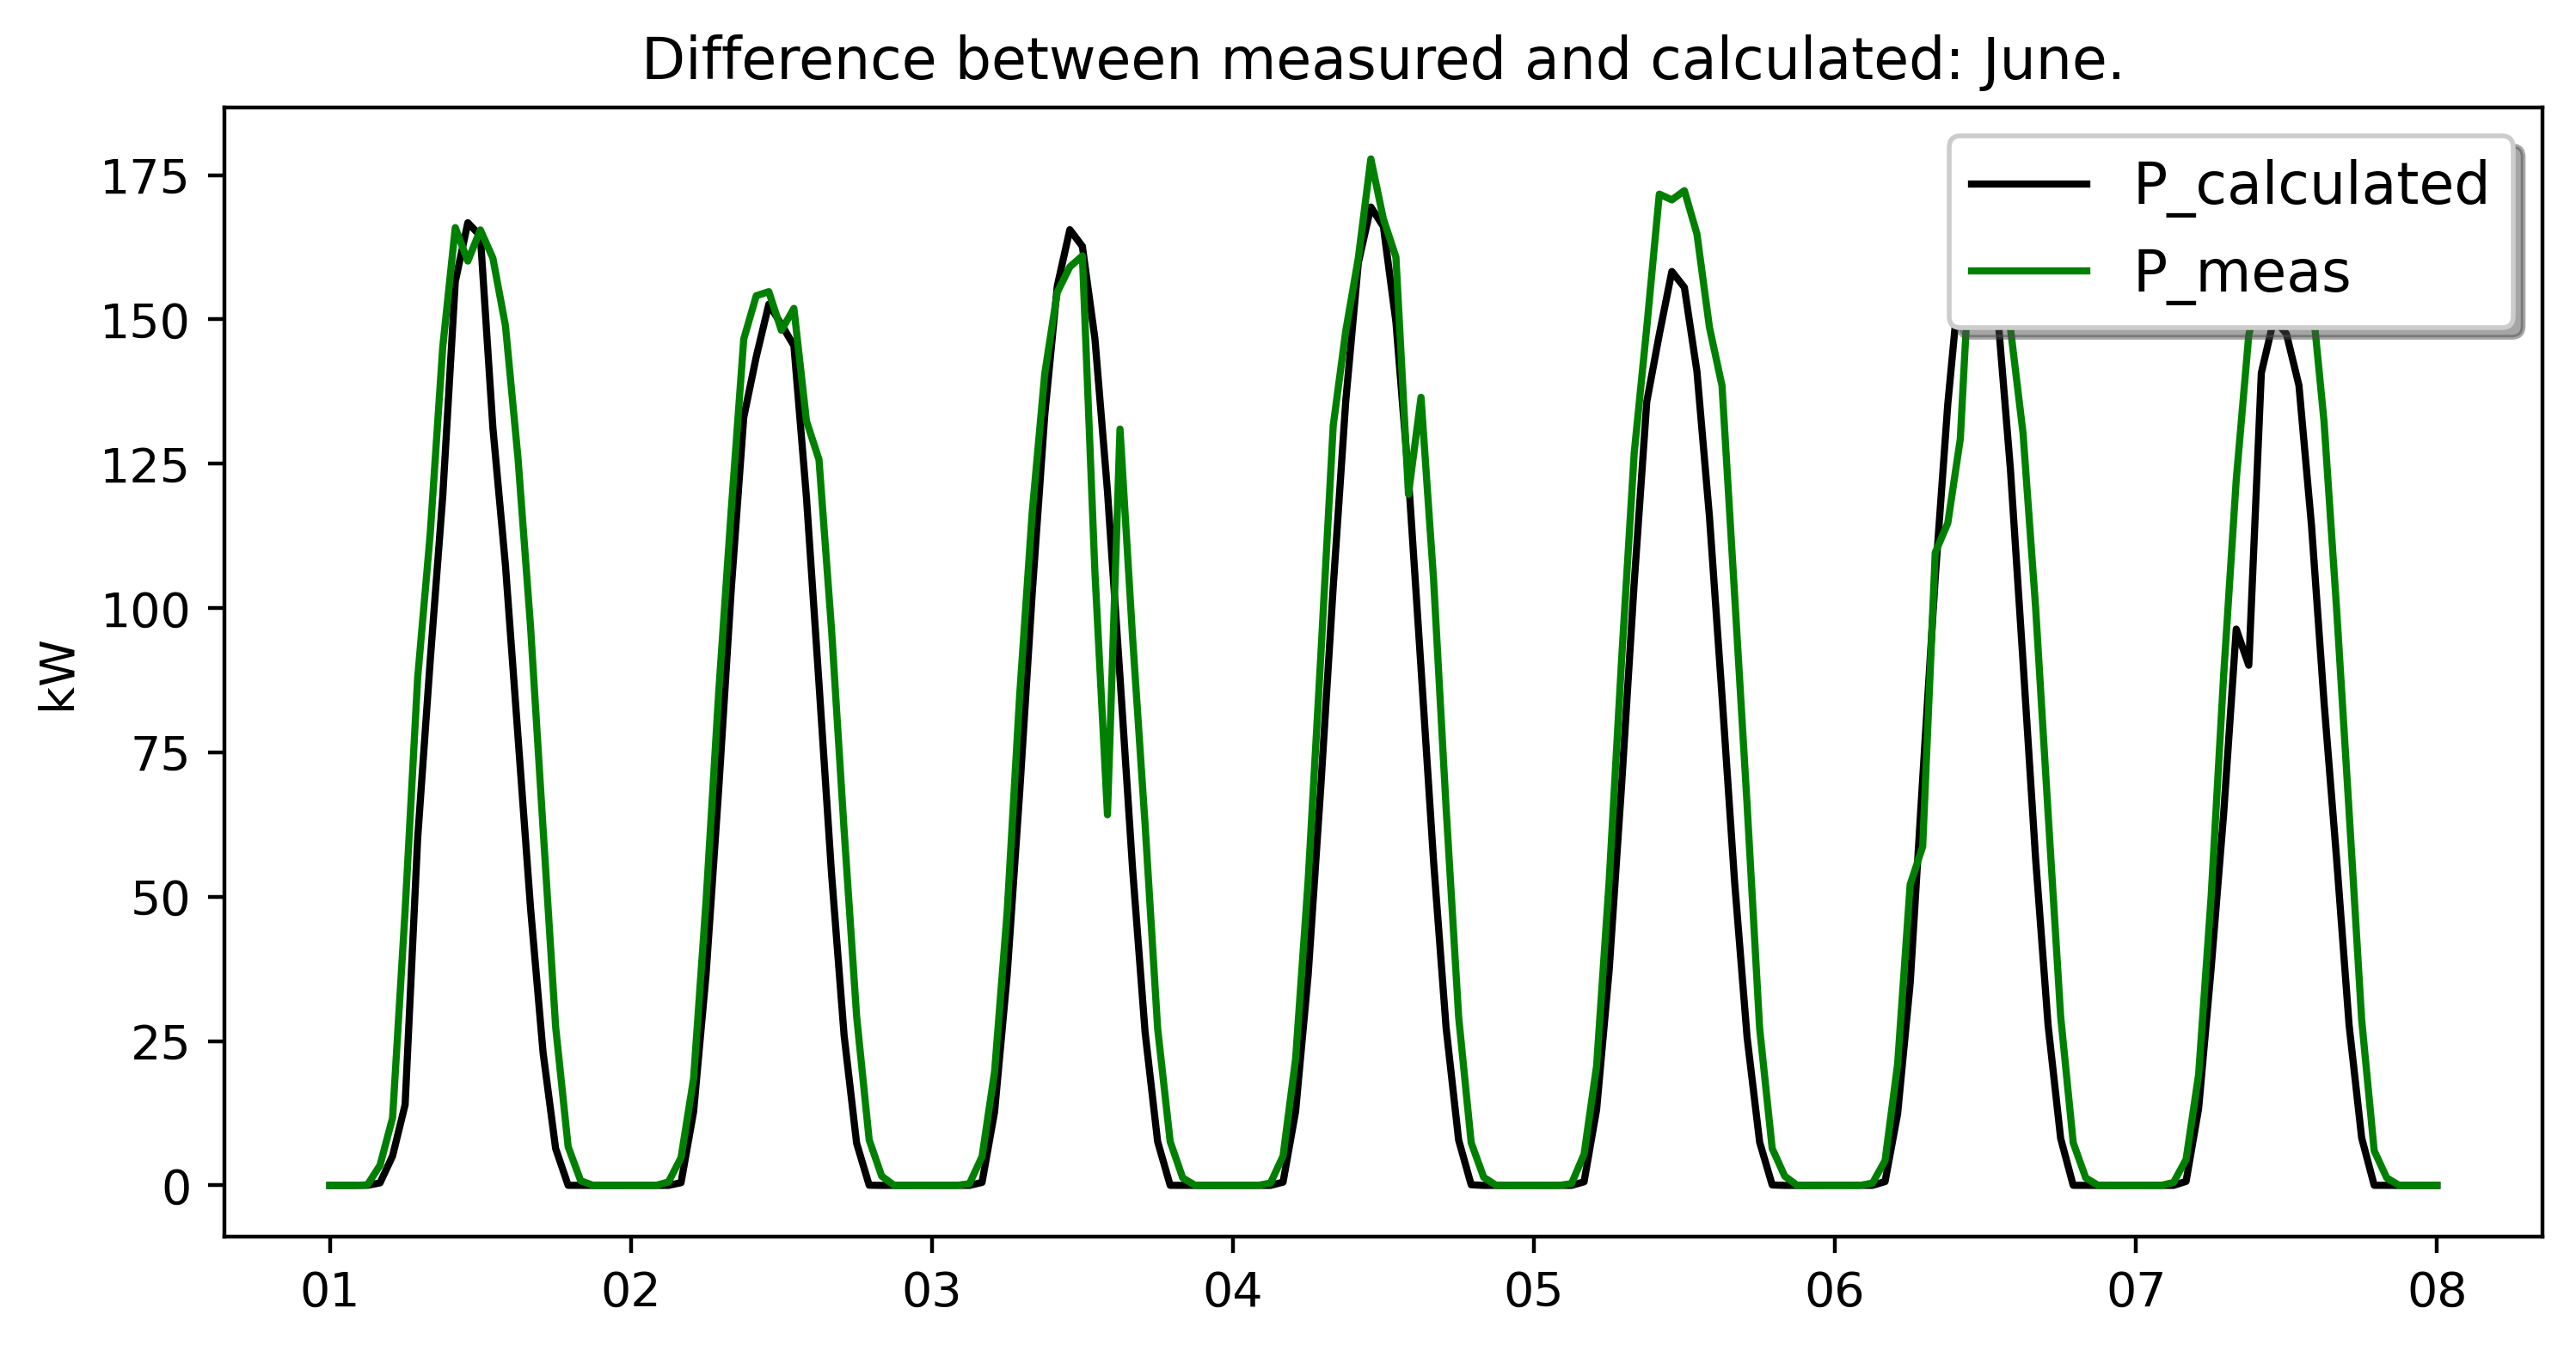

In [ ]:
# plot
plt.figure(figsize=(20, 10), dpi=400)
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.3, hspace=0.3)
ax1 = plt.subplot(gs1[0,0])
ax1.plot(timeseries['P']['2018-06-01 00:00':'2018-06-08 00:00'], 
         label='P_calculated', color='black')
ax1.plot(timeseries['P_meas']['2018-06-01 00:00':'2018-06-08 00:00'], 
         label='P_meas', color='green')
plt.title('Difference between measured and calculated: June.')
ax1.legend(fancybox=True, shadow=True,fontsize=12, loc='upper right')
ax1.set_ylabel('kW')
date_form = mdates.DateFormatter("%d")
ax1.xaxis.set_major_formatter(date_form)

plt.show()

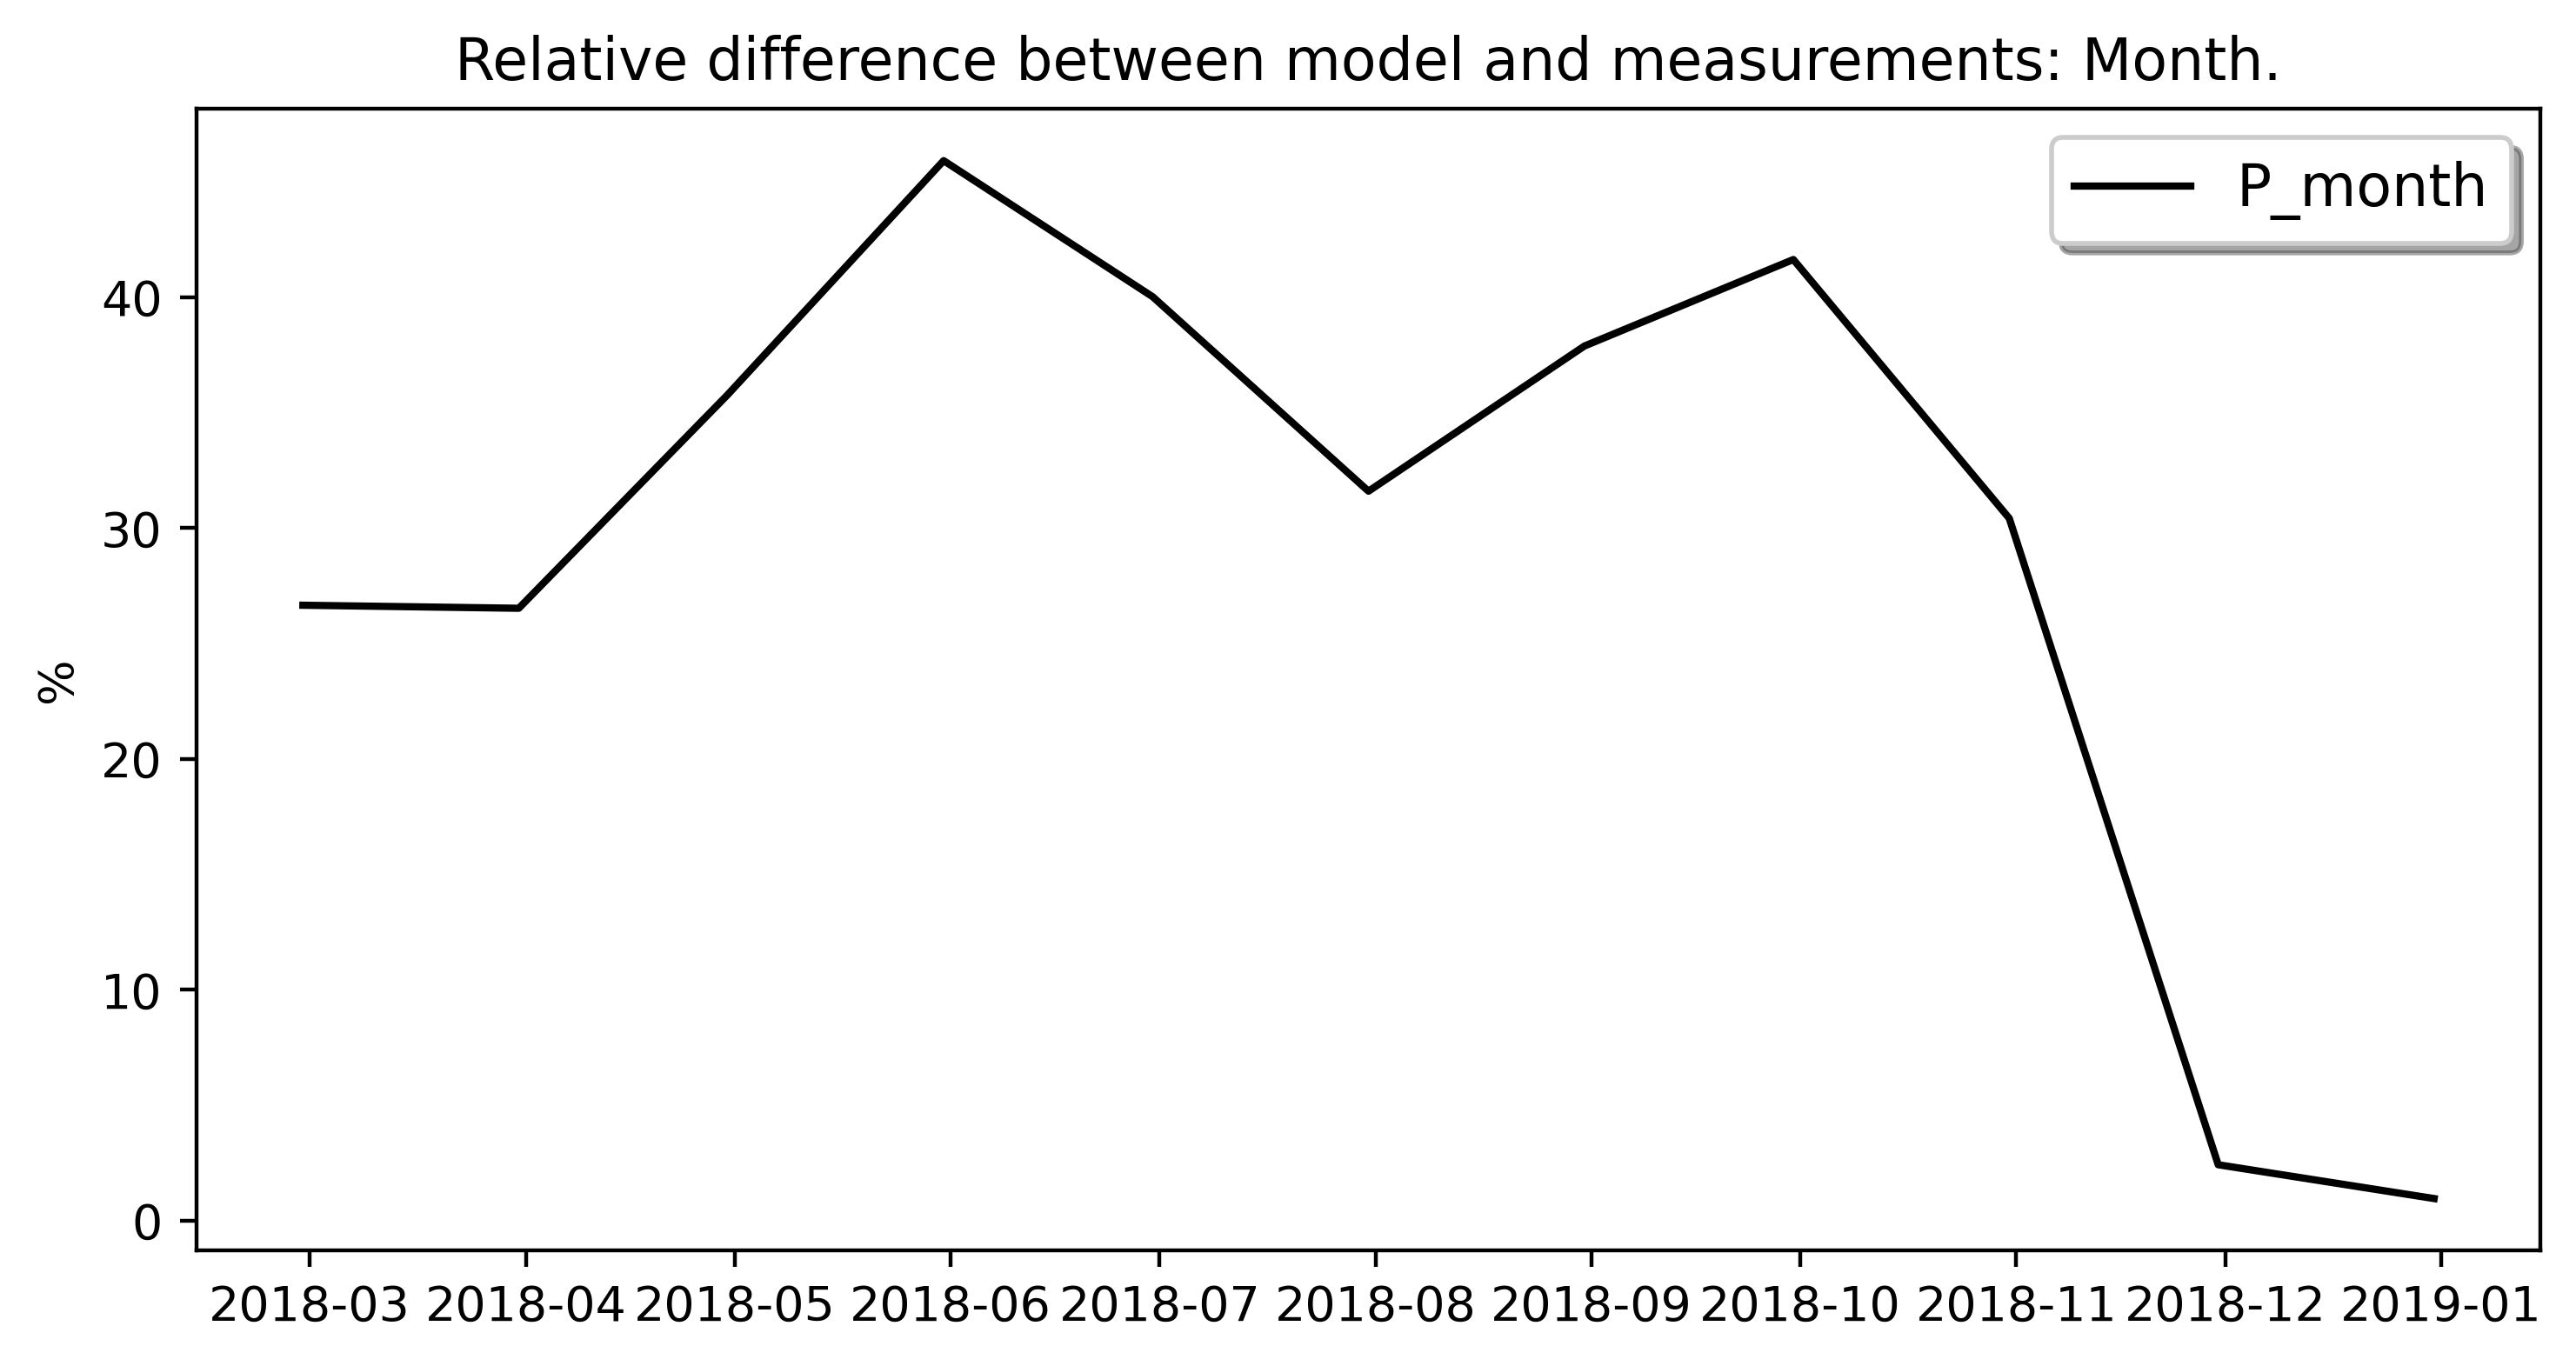

In [ ]:
# plot
plt.figure(figsize=(20, 10), dpi=400)
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.3, hspace=0.3)
ax1 = plt.subplot(gs1[0,0])
ax1.plot((PEmonth['P_meas']-PEmonth['P'])/PEmonth['P_meas'].mean()*100, 
         label='P_month', color='black')

plt.title('Relative difference between model and measurements: Month.')
ax1.legend(fancybox=True, shadow=True,fontsize=12, loc='upper right')
ax1.set_ylabel('%')
#date_form = mdates.DateFormatter("%m")
#ax1.xaxis.set_major_formatter(date_form)

plt.show()

In [ ]:
timeseries['2018-03-01 16:00':'2018-03-03 00:00']

names,B_0_h,K_t,G_ground_h,solar_altitude,F,B_ground_h,D_ground_h,incident_angle,B_tilted,D_tilted,R_tilted,G_tilted,FD,Tc,P,P_total,P_meas
utc_time,,,,,,,,,,,,,,,,,
2018-03-01 16:00:00,126.279544,0.7,88.395681,5.209508,0.191771,31.822445,56.573236,78.390253,6.40409,0.781562,0.061059,7.24672,0.64,-3.373540,2.078612,2078.612339,9.10
2018-03-01 17:00:00,0.000000,0.7,0.000000,0.000000,0.167274,0.000000,0.000000,88.850396,0,0.000000,0.000000,0,0.64,-4.600000,0.000000,0.000000,2.00
2018-03-01 18:00:00,0.000000,0.7,0.000000,0.000000,0.141840,0.000000,0.000000,99.755997,0,0.000000,0.000000,0,0.76,-4.500000,0.000000,0.000000,0.00
2018-03-01 19:00:00,0.000000,0.7,0.000000,0.000000,0.117203,0.000000,0.000000,110.755900,0,0.000000,0.000000,0,0.76,-5.100000,0.000000,0.000000,0.00
2018-03-01 20:00:00,0.000000,0.7,0.000000,0.000000,0.100000,0.000000,0.000000,121.475773,0,0.000000,0.000000,0,0.76,-4.700000,0.000000,0.000000,0.00
2018-03-01 21:00:00,0.000000,0.7,0.000000,0.000000,0.100000,0.000000,0.000000,131.397008,0,0.000000,0.000000,0,0.64,-5.100000,0.000000,0.000000,0.00
2018-03-01 22:00:00,0.000000,0.7,0.000000,0.000000,0.100000,0.000000,0.000000,139.668238,0,0.000000,0.000000,0,0.64,-4.600000,0.000000,0.000000,0.00
2018-03-01 23:00:00,0.000000,0.7,0.000000,0.000000,0.100000,0.000000,0.000000,144.563171,0,0.000000,0.000000,0,0.64,-4.700000,0.000000,0.000000,0.00
2018-03-02 00:00:00,0.000000,0.7,0.000000,0.000000,0.100000,0.000000,0.000000,145.271828,0,0.000000,0.000000,0,0.64,-4.700000,0.000000,0.000000,0.00
